In [70]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import os
import logging
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [71]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


### Path

In [72]:
main_dir = r"D:\1 Main File\Project File\Capstone Bangkit\MakeDataset6"
dataset_dir = os.path.join(main_dir, 'dataset')
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')
log_path = os.path.join(main_dir, 'training_log.txt')
model_path = os.path.join(main_dir, 'newmodel.h5')
os.makedirs(main_dir, exist_ok=True)
os.makedirs(main_dir, exist_ok=True)

### Preprocessing

In [73]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

In [74]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 14352 images belonging to 4 classes.
Found 3144 images belonging to 4 classes.
Found 1191 images belonging to 4 classes.


### Load ResNet50

In [75]:
# Load pretrained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

### Custom Layers and fine-tuning

In [76]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

### Build model

In [77]:
model = Model(inputs=base_model.input, outputs=predictions)

### Training callback

In [ ]:
import tensorflow as tf

class MonitorTraining(tf.keras.callbacks.Callback):
    def __init__(self, patience=3, overfit_gap=0.2, underfit_threshold=1.0):
        super(MonitorTraining, self).__init__()
        self.patience = patience
        self.overfit_gap = overfit_gap
        self.underfit_threshold = underfit_threshold
        self.wait = 0
        self.best_val_loss = float('inf')
        self.reason = None
        self.previous_train_loss = float('inf')  # Menyimpan loss dari epoch sebelumnya

    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        # underfit
        if train_loss > self.underfit_threshold:
            self.reason = (
                f"\nTraining is stopped due to underfit at epoch {epoch}. \n"
                f"Train_loss: {train_loss:.4f} > Underfit threshold: {self.underfit_threshold:.4f}")
            print(self.reason)
            self.model.stop_training = True
            return

        # overfit
        loss_gap = abs(val_loss - train_loss)
        if loss_gap > self.overfit_gap:
            self.wait += 1
            if self.wait >= self.patience:
                self.reason = (
                    f"\nTraining is stopped due to overfit at epoch {epoch}.\n"
                    f"Loss gap: {loss_gap:.4f} > Overfit gap: {self.overfit_gap:.4f}\n"
                    f"For {self.patience} consecutive epochs."
                )
                print(self.reason)
                self.model.stop_training = True
        else:
            # Reset counter
            self.wait = 0
            self.best_val_loss = min(self.best_val_loss, val_loss)

        # Stop training if current train loss is worse than previous
        if train_loss > self.previous_train_loss:
            self.reason = (
                f"\nTraining is stopped because the training loss increased at epoch {epoch}.\n"
                f"Current Train Loss: {train_loss:.4f} > Previous Train Loss: {self.previous_train_loss:.4f}"
            )
            print(self.reason)
            self.model.stop_training = True

        # Update previous train loss
        self.previous_train_loss = train_loss

    def on_train_end(self, logs=None):
        # best fit
        if self.reason is None:
            print("\nTraining is completed without overfit or underfit detection.")

In [79]:
# Callback MonitorTraining
monitor_training = MonitorTraining(
    patience=5,
    overfit_gap=0.3,
    underfit_threshold=1.0
)

In [80]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [81]:
logging.basicConfig(filename=log_path, level=logging.INFO)

In [82]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[monitor_training]
)

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 2565s 6s/step - accuracy: 0.5007 - loss: 1.1554 - val_accuracy: 0.3232 - val_loss: 1.4059
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 2505s 6s/step - accuracy: 0.9454 - loss: 0.1962 - val_accuracy: 0.9491 - val_loss: 0.1648
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 2504s 6s/step - accuracy: 0.9894 - loss: 0.0509 - val_accuracy: 0.9857 - val_loss: 0.0517
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 2504s 6s/step - accuracy: 0.9933 - loss: 0.0255 - val_accuracy: 0.9863 - val_loss: 0.0510
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 2514s 6s/step - accuracy: 0.9970 - loss: 0.0143 - val_accuracy: 0.9889 - val_loss: 0.0425
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 2507s 6s/step - accuracy: 0.9983 - loss: 0.0093 - val_accuracy: 0.9873 - val_loss: 0.0510
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 2508s 6s/step - accuracy: 0.9982 - loss: 0.0066 - val_accuracy: 0.9911 - val_loss: 0.0380
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 2519s 6s/step - accuracy: 0.9993 - loss: 0.0036 - 

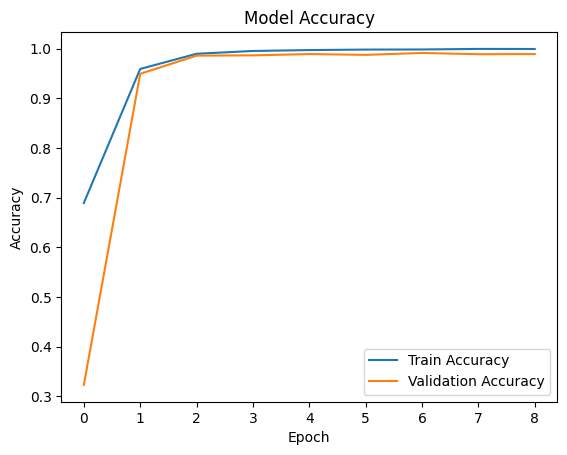

In [83]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

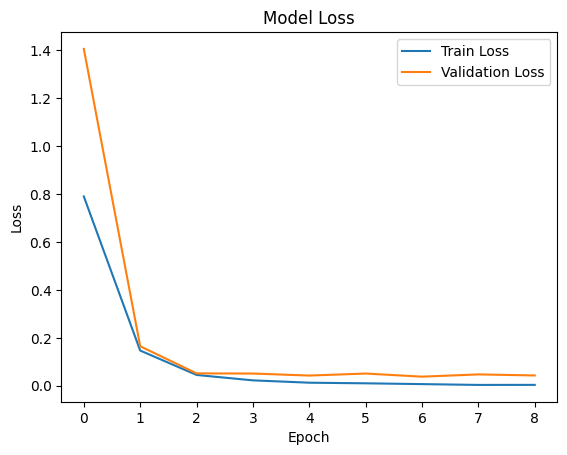

In [84]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [85]:
model.save(model_path)
print(f"Model saved as {model_path}")

Model saved as D:\1 Main File\Project File\Capstone Bangkit\MakeDataset6\newmodel.h5


In [86]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

38/38 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9497 - loss: 0.3320
Test Loss: 0.2291, Test Accuracy: 0.9631


In [87]:
prediction = model.predict(test_generator)
predicted_class_indices = tf.argmax(prediction, axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step


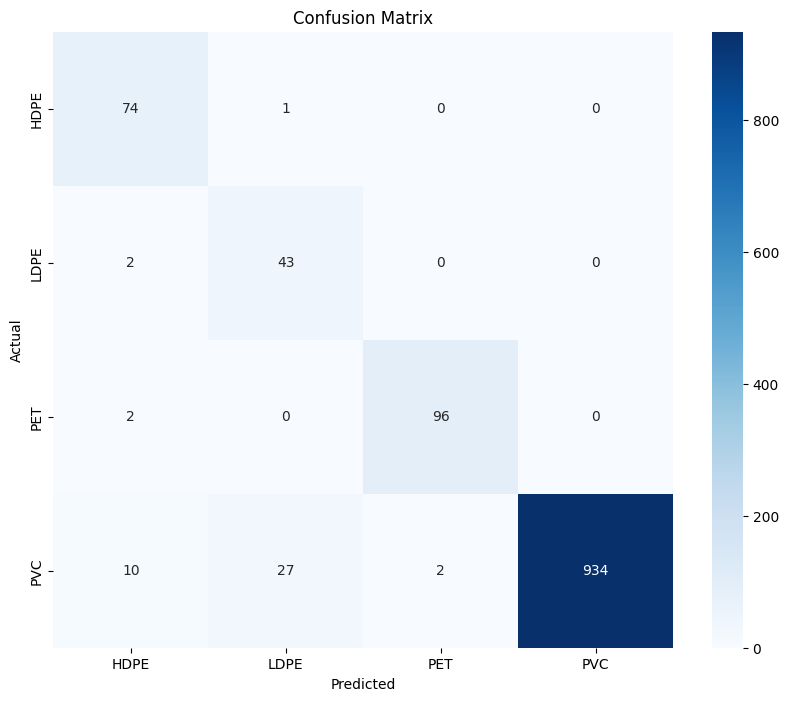

In [88]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [89]:
report = classification_report(true_classes, predicted_class_indices, target_names=class_labels)
print(report)
logging.info("Test Loss: %.4f, Test Accuracy: %.4f".format(test_loss, test_acc))
logging.info("Classification Report: \n{}" + report)

              precision    recall  f1-score   support

        HDPE       0.84      0.99      0.91        75
        LDPE       0.61      0.96      0.74        45
         PET       0.98      0.98      0.98        98
         PVC       1.00      0.96      0.98       973

    accuracy                           0.96      1191
   macro avg       0.86      0.97      0.90      1191
weighted avg       0.97      0.96      0.97      1191

